# Chest x-ray diagnosis using deep learning models
# Data exploration and sampling to deal with unbalanced train data and improve F1 score for all observations
## The model structure to study: DenseNet-121
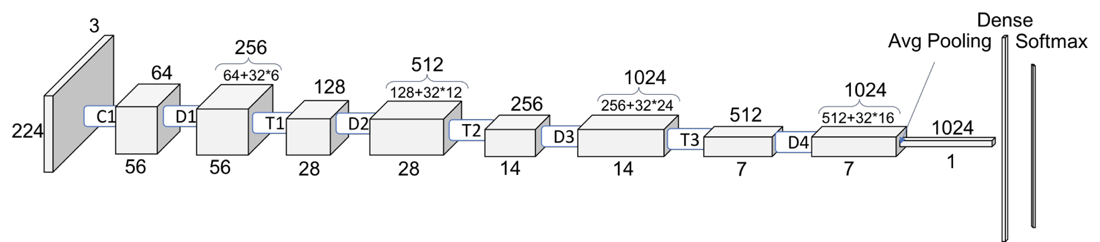

## Data Source: Stanford ChexPert Data - [CheXpert-v1.0-small]( https://stanfordmlgroup.github.io/competitions/chexpert/)

Note that in the last study on DenseNet-121, we trained the whole model and got good accuracy results. However the F1 score results on a few observations were very low. We also tried other model structures such as VGG-16 and ResNet but it did not help in fixing the F1-score issue. Here in this study, we first conduct further analysis on the data to show the issue of unbalanced data comparing different observations. Then we will use a re-sampling approach to balance class labels ad will get much better F1-score results on all observations. 

In [1]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#import pydotplus
#import pydot as pyd
#from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


## data preprocessing
- Only frontal images are considered in my project. I remove latteral images.
- Only x-ray images considered as input to the model. "Sex", "Age", "Frontal/Lateral", and "AP/PA" features were removed from training data
- Combined the downloaded validation data with train data as the validation data from the download link is very small comparing to the training data(200 images versus almost 200K images in training data)


In [2]:
dtrain=pd.read_csv("CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)
# import valid data info from valid.csv
dnew=pd.read_csv("CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dnew)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
#pre-process data: drop selected features - only images as inputs
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)
#print(dtrain.shape)
#dtrain.describe().transpose()

 - Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were consdiered as positive (replaced -1 by 1)
 - Data statistics show Lung Opacity, Edema, Atelectasis, Pleural Effusion and Support Devices have more balanced positive versus negative cases. The resut of observations have less than 25% of positive observations

In [3]:
# dealing with uncertanty (-1) values
dtrain = dtrain.replace(-1,1)
dtrain.describe().transpose()
print(list(dtrain.columns))
#print(len(list(dtrain.columns)))
print(list(dtrain.columns[1:15]))

['Path', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


# ** Further Data Analysis **

In [4]:
features_size=[]
features_data =[]
features_name=[]
#print(list(dtrain.columns[1:15]))
for feature in list(dtrain.columns[1:15]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)
    
print(dtrain.shape)
print(list(dtrain.columns[1:15]))
#print(features_name)
#print(list(dtrain.columns))
print(features_size)
print(np.array(features_size)/dtrain.shape[0]*100)
#print(len(list(dtrain.columns[1:15])))
#print(len(features_data[0]))
#aa=features_data[0]
#print(features_data[0][0:2])


(191229, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
[17000, 19578, 30158, 98759, 8149, 61535, 37396, 20664, 59658, 20408, 86541, 4318, 7935, 108184]
[ 8.88986503 10.23798692 15.77062056 51.64436356  4.26138295 32.17869675
 19.55561134 10.80589241 31.19715106 10.6720215  45.25516527  2.25802572
  4.14947524 56.57300932]


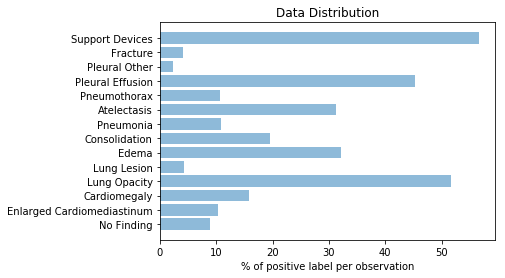

<Figure size 432x288 with 0 Axes>

In [5]:
%matplotlib inline
objects = list(dtrain.columns[1:15])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')


The results indicate the unbalanced data issue for different observations. As you can see, the number of training data for Fracture, Pleural Other, and Lung Leison observations are very low comparing to for example the ones for Lung Opacity, Pleural Effusion or Support Device. Lets look at the correlation between observations to see if we can upsample the data for the observations with low training data. 

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


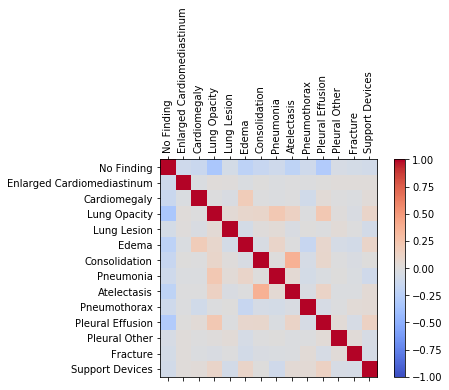

<Figure size 432x288 with 0 Axes>

In [6]:
#dtrain.corr(method='pearson')
#print(list(dtrain.columns[1:15]))
data = dtrain[list(dtrain.columns[1:15])]
print(list(dtrain.columns[1:15]))
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()
plt.savefig('Correlation.png', bbox_inches='tight')


The correlation matrix above indicates low correlation between Lung Leision, Fracture and Pleural Other (3 of classes with low data) with the other classes particularly the ones with high data such as Lung Opacity. This would enable us to upsample these observations to balance the data further. Although there are also other approaches to deal with unbalanced data such as weighted loss, the upsampling method has similar impact without changing the model structure or loss function. This approach is implemented here. 

In [7]:
dtrain_upsample=[]
dtrain_upsample_list=[]
# dtrain_upsample_list = [features_data[0],
#                        features_data[1],
#                        features_data[2],
#                        features_data[3],
#                        features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],
#                        features_data[5],
#                        features_data[6],
#                        features_data[7],
#                        features_data[8],
#                        features_data[9],
#                        features_data[10],
#                        features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],
#                        features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],
#                        features_data[13]]
dtrain_upsample_list = [features_data[0],features_data[0],features_data[0],features_data[0],
                       features_data[1],
                       features_data[2],
                       features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],
                       features_data[5],
                       features_data[6],
                       features_data[7],
                       features_data[8],
                       features_data[9],
                       features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],
                       features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12]]

dtrain_upsample = pd.concat(dtrain_upsample_list) 
print(dtrain_upsample.shape)
print(list(dtrain_upsample.columns[1:15]))

(497398, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


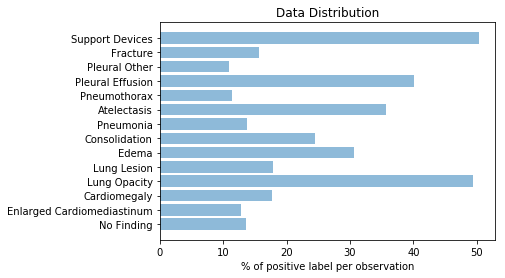

<Figure size 432x288 with 0 Axes>

In [8]:
features_sizeR=[]
features_dataR =[]
features_nameR=[]
#print(list(dtrain.columns[1:15]))
for featureR in list(dtrain_upsample.columns[1:15]):
    data_featureR = dtrain_upsample.loc[dtrain_upsample[featureR] == 1]
    features_sizeR.append(data_featureR.shape[0])
    features_dataR.append(data_featureR)
    features_nameR.append(featureR)

objectsR = list(dtrain_upsample.columns[1:15])
y_posR = np.arange(len(objectsR))
performanceR = np.array(features_sizeR)/dtrain_upsample.shape[0]*100

plt.barh(y_posR, performanceR, align='center', alpha=0.5)
plt.yticks(y_posR, objectsR)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute_balanced.png', bbox_inches='tight')

As it is observed above, the balance between observation is improved with this upsampling approach. However this increases the train data size and makes the training time slower. Now we split data to train/dev/test with 10% of data used for development and test

In [9]:
### split data into train/valid/test
#shuffle data 
dtrain_upsample = dtrain_upsample.sample(frac=1)
#split data
dvalid_size = round(0.1*dtrain_upsample.shape[0])
dtest_size = dvalid_size
dtr = dtrain_upsample[0:dtrain_upsample.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size-dtest_size:dtrain_upsample.shape[0]-dvalid_size+1]
dte = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size:dtrain_upsample.shape[0]+1]


In [10]:
print(dtr.shape)
#dtr.describe().transpose()

(397919, 15)


In [11]:
print(dv.shape)
#dv.describe().transpose()

(49741, 15)


In [12]:
print(dte.shape)
#dte.describe().transpose()

(49740, 15)


 - Image target size as input to the model are **224*224**
 - Batch size is set to **32** for training and validation set. 
 - For test set, shuffle is set to false to be able to compute F1 score later through prediction of test data. 

In [13]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

target_size = (224,224)
#target_size = (299,299)
#target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , x_col="Path", y_col=list(dtr.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, batch_size=32)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None, x_col="Path", y_col=list(dv.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, batch_size=32)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None, x_col="Path", y_col=list(dte.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, shuffle = False, batch_size=1)


Found 397919 images.
Found 49741 images.
Found 49740 images.


- DenseNet-121 is selected for CNN structure. A global average 2D pooling layer, a fully connected dense layer with 1024 nodes and Relu activation, and finally a fully connected dense layer with 14 nodes (representing 14 classes for chest x-ray observations) and sigmoid activation are added to modify DenseNet-121 architecture for our application. The weights are initialized with a network weights tuned for imagenet data. <font color=blue>All weights are tuned.</font>
- loss function is defined as binary cross entropy loss. 
- Adam optimizer selected with lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None.


In [14]:
### model architecture design/selection
# create the base pre-trained model
base_model = DenseNet121(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer 
predictions = Dense(14, activation='sigmoid')(x)


# this is the model we will train
model_F = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model_F.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________________

Fit the model on aws with epochs = 3. Model is saved after fiting is done.

In [15]:
### fit model 
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)
# save model
model_F.save("model_DenseNet121_Full_Sample.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
12434/12434 [==============================] - 11426s 919ms/step - loss: 0.3691 - acc: 0.8346 - val_loss: 0.3093 - val_acc: 0.8635
Epoch 2/3
12434/12434 [==============================] - 11390s 916ms/step - loss: 0.2513 - acc: 0.8914 - val_loss: 0.2425 - val_acc: 0.8956
Epoch 3/3
12434/12434 [==============================] - 11384s 916ms/step - loss: 0.1944 - acc: 0.9167 - val_loss: 0.2201 - val_acc: 0.9064


load the trained model here.

In [15]:
model_F = load_model('model_DenseNet121_Full_Sample.h5')
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Instructions for updating:
Use tf.cast instead.


Now lets calculate precision, recall, and f1-score on test data. **The threshold for positive is set to 0.5**
As it can be seen in the table below, all perfromance indexes particularly F1 score are improved significantly. 

In [16]:
### prediction and performance assessment
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.94      0.83      0.88      6834
Enlarged Cardiomediastinum       0.87      0.52      0.65      6299
              Cardiomegaly       0.75      0.81      0.78      8784
              Lung Opacity       0.84      0.83      0.83     24487
               Lung Lesion       0.96      0.94      0.95      8821
                     Edema       0.84      0.82      0.83     15215
             Consolidation       0.65      0.82      0.73     12342
                 Pneumonia       0.84      0.60      0.70      6918
               Atelectasis       0.85      0.71      0.77     17766
              Pneumothorax       0.90      0.68      0.77      5595
          Pleural Effusion       0.86      0.91      0.88     20046
             Pleural Other       0.93      0.98      0.95      5375
                  Fracture       0.89      0.98      0.93      7767
           Support Devices       0.90      0.91

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Calculate accuracy on test data

In [17]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.18624548949727385
Test accuracy: 0.9206114595105095


Now let's calculate precision, recal, and F1 score on the original test set used for other models assessment. For this purpuse, we repeat the split of data before up-sampling to balance class labels. 

In [20]:
### split data into train/valid/test
#dtrain = dtrain.sample(frac=1)
dvalid_size = round(0.1*dtrain.shape[0])
dtest_size = dvalid_size
#dtr_o = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
#dv_o = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte_o = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]
print(dte_o.shape)
### data generation for Keras 
test_o_datagen=ImageDataGenerator(rescale=1./255.)
target_size = (224,224)
test_o_generator=test_o_datagen.flow_from_dataframe(dataframe=dte_o, directory=None, x_col="Path", y_col=list(dte_o.columns[1:15]), class_mode="other", target_size=target_size, shuffle = False, batch_size=1)
STEP_SIZE_TEST_O=test_o_generator.n//test_o_generator.batch_size


(19123, 15)
Found 19123 images.


Calculate precision, recall, and f1-score on original test data prior upsampling for balancing to compare with the other models on the same test set. It is seen that the F1 score results are significantly improved on the original test set. 

In [21]:
### prediction and performance assessment
test_o_generator.reset()
pred=model_F.predict_generator(test_o_generator, steps=STEP_SIZE_TEST_O)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte_o.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.72      0.84      0.77      2291
Enlarged Cardiomediastinum       0.63      0.32      0.42      2100
              Cardiomegaly       0.58      0.70      0.64      2662
              Lung Opacity       0.74      0.71      0.73      9283
               Lung Lesion       0.71      0.95      0.81       861
                     Edema       0.69      0.73      0.71      5619
             Consolidation       0.43      0.76      0.55      3643
                 Pneumonia       0.64      0.45      0.52      2042
               Atelectasis       0.66      0.65      0.66      6581
              Pneumothorax       0.64      0.51      0.57      1439
          Pleural Effusion       0.77      0.76      0.77      6775
             Pleural Other       0.59      0.96      0.73       314
                  Fracture       0.52      0.99      0.68       880
           Support Devices       0.85      0.83

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [37]:
indx=1000
print(y_pred[indx])
print(y_true[indx])

[0 0 0 1 0 1 0 1 1 0 0 0 1 0]
[0 0 0 1 0 1 0 1 1 0 0 0 1 0]


In [38]:
score, acc = model_F.evaluate_generator(test_o_generator, steps=STEP_SIZE_TEST_O)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.28497016770311495
Test accuracy: 0.8774997889995575
